In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Read in data
RawDrainageData=pd.read_csv('K:\Rainshelter\StonySoilLysimeters\DownloadedData\StonyLysimetersDrain.dat', #specify file path for data to read in
                         parse_dates=True, #tell the function to parse date columns to datetime formats
                         dayfirst=True, #tell the function that the day is before the year in the data i.e format='%d/%m/%Y %H:%M'
                         skiprows = [0,2,3], #leave out rows 1, 3 and 4 which have redundant information
                         #index_col = 0, #Use the first column, which is Date, as an index
                         na_values = 'NAN')

In [3]:
#Read in data
RawDrainageData=pd.read_csv('K:\Rainshelter\StonySoilLysimeters\DownloadedData\StonyLysimetersDrain.dat', #specify file path for data to read in
                         parse_dates=True, #tell the function to parse date columns to datetime formats
                         dayfirst=True, #tell the function that the day is before the year in the data i.e format='%d/%m/%Y %H:%M'
                         skiprows = [0,2,3], #leave out rows 1, 3 and 4 which have redundant information
                         index_col = 0, #Use the first column, which is Date, as an index
                         na_values = 'NAN')
#Drop empty columns
RawDrainageData.drop(['RECORD','BattV_Avg','PTemp_C_Avg','AirTC_Avg','RH_Max','SlrkW_Avg','SlrMJ_Tot','Rain_mm_Tot','WS_ms_Avg'],axis=1,inplace=True)

#Bring in all index data
DrainageDataIndex=pd.read_csv('D:\GitHubRepos\StonySoilLysimeters\IndexFiles\DrainageIndex.csv',
                         index_col = 0)
DrainageDataIndex = DrainageDataIndex.ix[4:28,1:4]
#Apply indexes to data
DrainageDataTransposed = RawDrainageData.transpose()
DrainageDataIndexed = pd.concat([DrainageDataIndex,DrainageDataTransposed], axis=1)
DrainageDataIndexed.index.name='ColumnHeader',
#DrainageDataIndexed.set_index(['Measurement','Gravels','Stones','Column','Sensor', 'MUX', 'Port','Units','Summary','Block','Treatment'], 
#                        append=False, inplace=True)
DrainageDataIndexed.set_index(['Gravels','Stones','Treatment'], 
                        append=False, inplace=True)
DrainageDataIndexed.sort_index(inplace=True)
DrainageData=DrainageDataIndexed.transpose()
DrainageData.index = DrainageData.index.to_datetime()  ## for some reason the concat function changes the data type on the date indes so need to change it back

In [4]:
ManualIndex = DrainageDataIndex
ManualIndex.set_index('Treatment', inplace=True)

In [5]:
ManualData = pd.read_excel('K:\Rainshelter\StonySoilLysimeters\Packing lysimeter drainage.xlsx',sheetname = 'DrainageCondensed',index_col=0)
ManualData.columns.name='Treatment'
MD = pd.concat([ManualIndex,ManualData.transpose()],axis=1)
MD.set_index(['Gravels','Stones'],inplace=True)
ManualData = MD.transpose()
ManualData.sort_index(axis=1,inplace=True)

##Calibrate spoon tips against measured drainage volumes

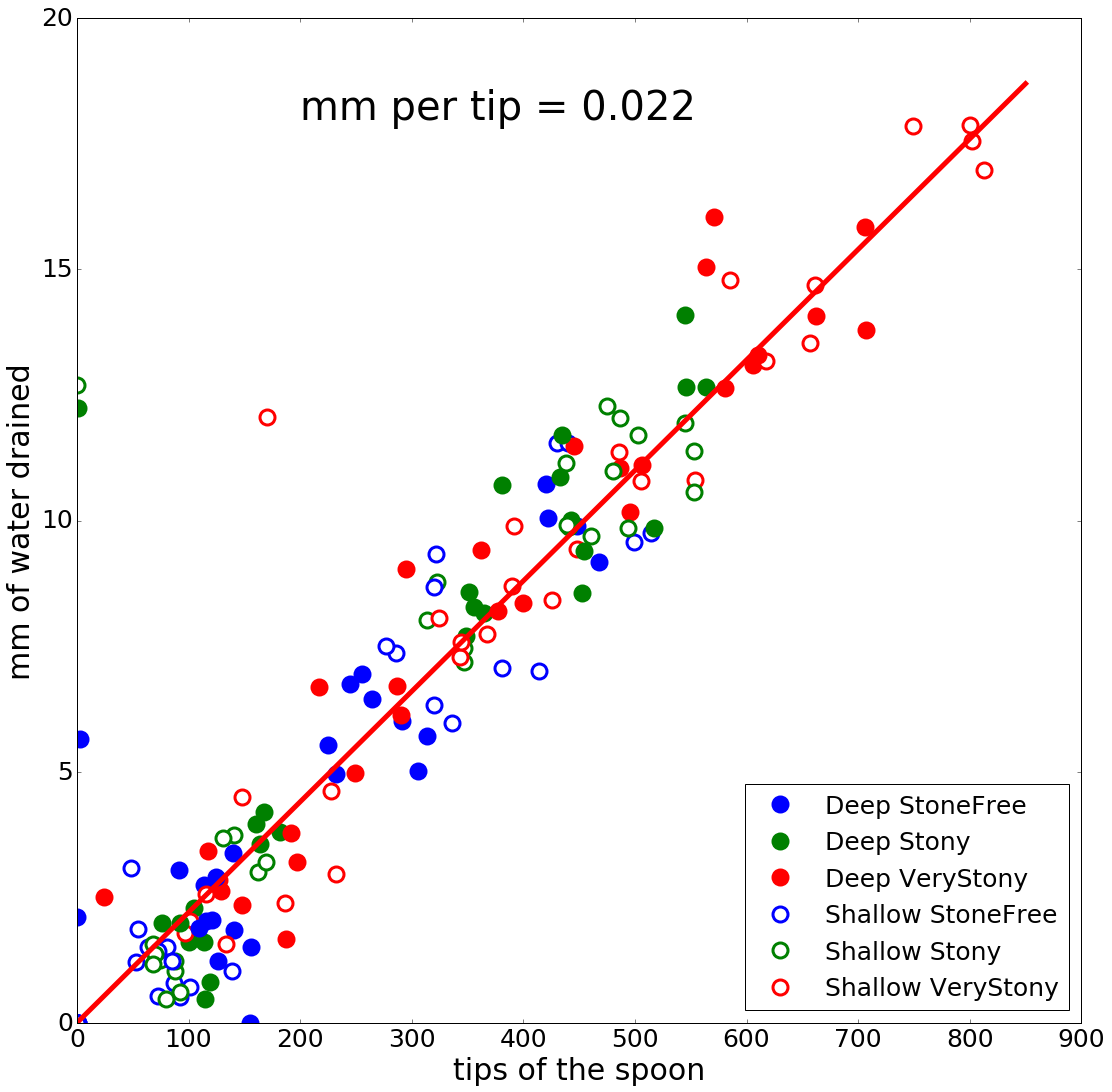

In [6]:
#area of the lysimeter
lysoArea = np.pi * np.power(0.25,2)

first = 15
last = 22
Observations = last - first
Observations = int(Observations)

fig = plt.figure(figsize=(18,18))

for obs in range(first,last):
    StartDate = ManualData.ix[obs,:].name
    EndDate = ManualData.ix[obs+1,:].name
    
    Gravels = ['Deep','Shallow']
    Stones = ['StoneFree','Stony','VeryStony']
    fills = ['b','g','r','w','w','w']
    colors = ['b','g','r']

    TreatPos = 0
    for Grav in Gravels:
        StonPos = 0
        for Ston in Stones:
            Tips = DrainageData.ix[StartDate:EndDate,(Grav,Ston)].sum(axis=0)
            #divide drainage by 1000 to convert to liters and divide by lysimeter area to convert to mm/m2
            #which is the same as mm drainage
            Drain = ManualData.ix[EndDate,(Grav,Ston)]/1000/lysoArea
            plt.plot(Tips,Drain,'o',markersize=15,mec = colors[StonPos],mfc = fills[TreatPos],mew=3, label = Grav+' ' +Ston)
            StonPos+=1
            TreatPos+=1
    if obs == 15:
        plt.legend(loc=4,numpoints=1,fontsize = 25)

mm_per_tip = .022
plt.plot([0,850],[0,850*mm_per_tip],'-',linewidth = 5,color='r')
plt.text(200,18,'mm per tip = '+str(mm_per_tip),fontsize=40)
plt.ylabel('mm of water drained', fontsize=30)
plt.xlabel('tips of the spoon', fontsize=30)
plt.tick_params(labelsize=25)


## Apply conversion

In [7]:
Drainage = DrainageData.multiply(mm_per_tip)
DrainageMeans = Drainage.groupby(level=['Gravels','Stones'],axis=1).mean()

In [8]:
Drainage.to_pickle('.\DataFrames\LysoDrainage_df')

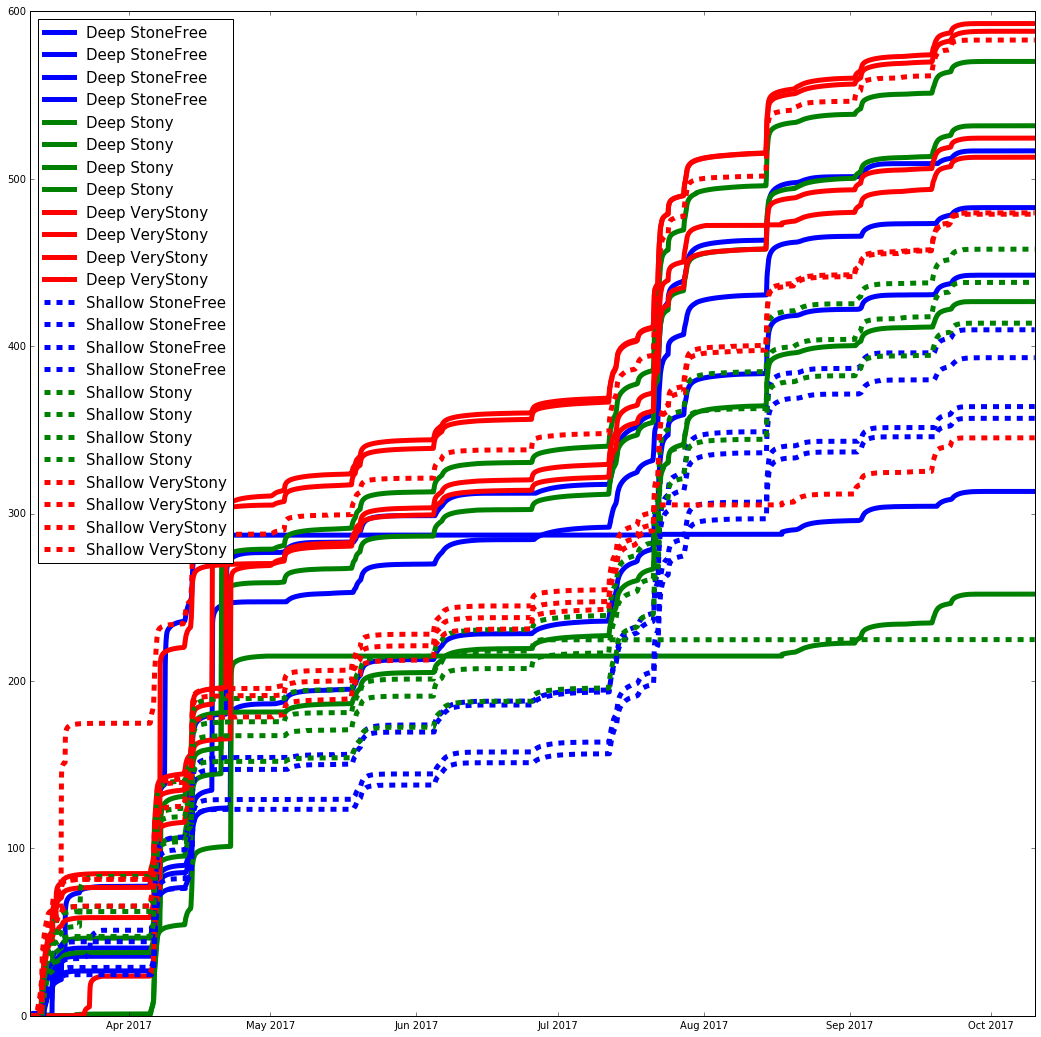

In [9]:
Gravels = ['Deep','Shallow']
Stones = ['StoneFree','Stony','VeryStony']
lines = ['-','--']
colors = ['b','g','r']

fig = plt.figure(figsize=(18,18))

GravPos = 0
for Grav in Gravels:
    StonPos = 0
    for Ston in Stones:
        plt.plot(Drainage.ix['2017-03-11':,(Grav,Ston)].index,
                 Drainage.ix['2017-03-11':,(Grav,Ston)].cumsum(),
                 lines[GravPos],
                color = colors[StonPos],
                linewidth = 5,
                label = Grav+' ' +Ston)
        StonPos += 1
    GravPos +=1
plt.legend(loc=2,numpoints=1,fontsize = 15)


In [10]:
RecentAccum = Drainage.ix['2017-09-1':,:].cumsum()
RecentAccum.ix[-1:,:].transpose()

2017-10-10 07:30:00
Gravels Stones    Treatment                     
Deep    StoneFree 10A                     17.160
                  16A                     17.468
                  23A                     15.422
                  6A                      20.438
        Stony     13B                     26.378
                  19B                     31.482
                  5B                      31.658
                  8B                      29.282
        VeryStony 11C                     32.692
                  15C                     30.932
                  24C                     31.614
                  4C                      33.000
Shallow StoneFree 14D                     20.108
                  20D                     20.724
                  2D                      21.736
                  7D                      23.122
        Stony     12E                     34.078
                  17E                     31.438
                  22E                      0.022
                  3E                      32.604
        VeryStony 18F                     37.026
                  1F                      36.630
                  21F                     33.594
                  9F                      37.312

In [11]:
Drainage.index.max()

Timestamp('2017-10-10 07:30:00')

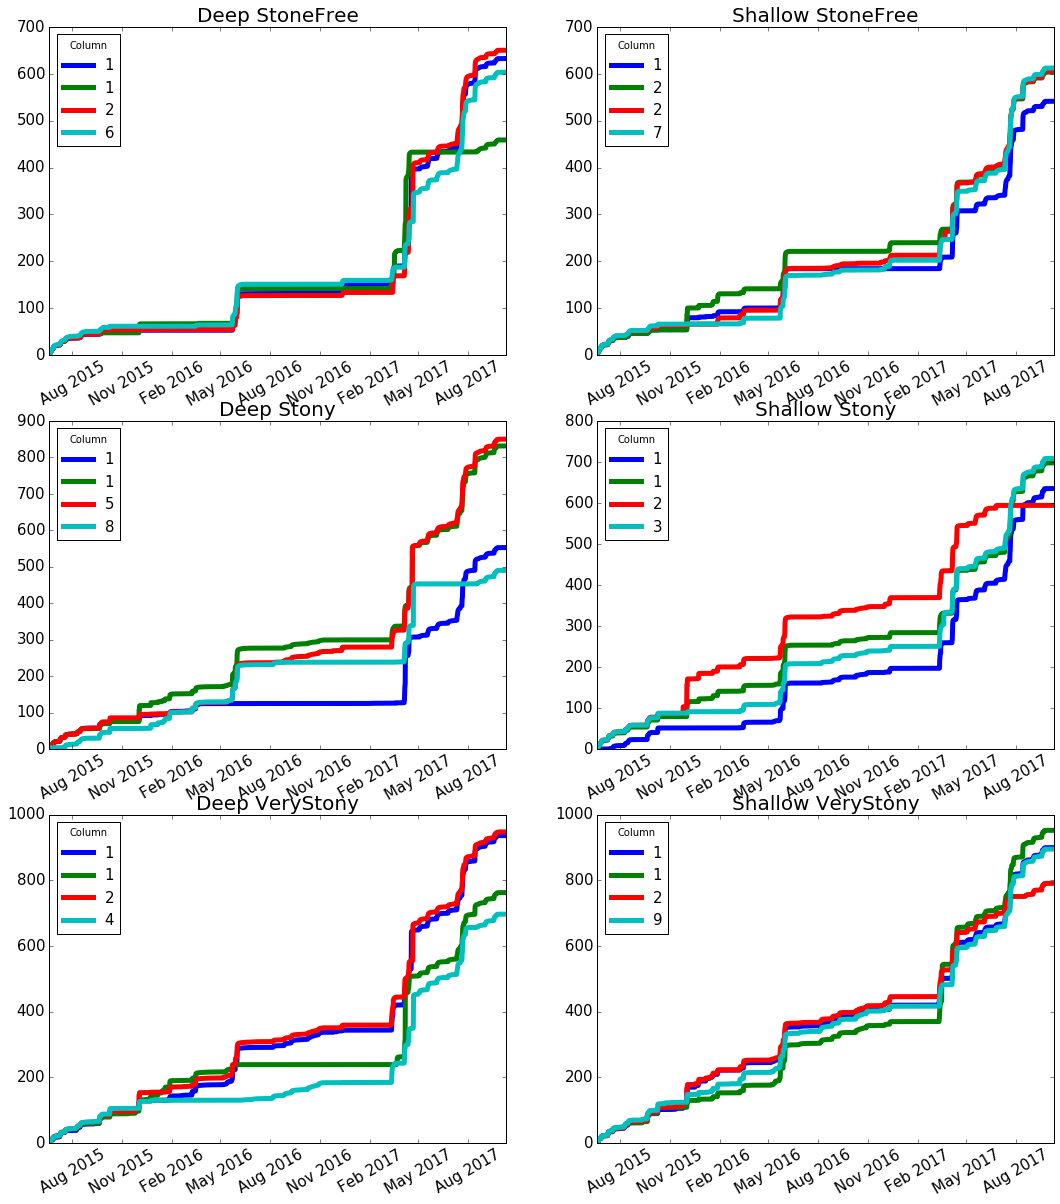

In [12]:
Gravels = ['Deep','Shallow']
Stones = ['StoneFree','Stony','VeryStony']
lines = ['-','--']
colors = ['b','g','r']

Graph = plt.figure(figsize=(18,20))

TreatPos = 1
for Ston in Stones:
    for Grav in Gravels:
        for rep in [0,1,2,3]:
            fig = Graph.add_subplot(3,2,TreatPos)
            Labels = Drainage.ix[:,(Grav,Ston)].ix[:,rep].name[0]
            plt.plot(Drainage.ix[:,(Grav,Ston)].ix[:,rep].index,
                     Drainage.ix[:,(Grav,Ston)].ix[:,rep].cumsum(),
                    linewidth = 5, label = Labels)
            plt.title(Grav+' ' +Ston, fontsize=20)
            plt.xticks(rotation=30)
            plt.tick_params(labelsize=15)
        TreatPos += 1
        plt.legend(loc=2,numpoints=1,fontsize = 15,title='Column')
    GravPos +=1
Graph.savefig('Drainage.jpg')

## Some periods where individual spoons have stoped working.  Need to replace data for these periods with means

First of all identify periods where individual spoons are not working.  These are days when a certian spoon does not tip but all of the others in the same treatment do

In [13]:
#Replace Nan values with zero
Drainage.fillna(0,inplace=True)
#Calculate daily drainage sums
DailyDrainage = Drainage.resample('D').sum()
#Make a data frame to hold 0 if data good and 1 if the spoon was not working
MissingDataMask = Drainage.copy()
MissingDataMask.ix[:] = 0

In [14]:
for plot in Drainage.columns:
    for date in DailyDrainage.index:
        Today = date.date().strftime('%Y-%m-%d')
        Treatment = plot[0:2]
        PlotValue = DailyDrainage.ix[Today,plot]
        TreatValues = DailyDrainage.ix[Today,Treatment]
        DrainCount = sum(i>0 for i in TreatValues)
        TreatMean = np.mean(TreatValues)
        #if plot didn't record drainage today, but at least two other did, it may be faulty
        if (PlotValue == 0) and (DrainCount >= 2):
            #if only one spoon recorded no data today or two spoons recorded data 
            #and there was > 5mm high drainage in the other two assume spoon is faulty 
            if (DrainCount == 3) or (TreatMean > 2.5):
                #Mark this plot as not working for this period
                MissingDataMask.ix[Today,plot] = 1.0

## Clearly see periods where some spoons were not tipping when others were.  For these periods replace the zero drainage recorded for the faulty spoons with the treatment mean.

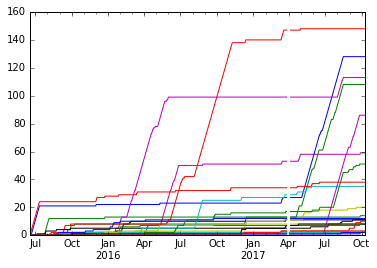

In [15]:
MissingDataMask.resample('D').mean().cumsum().plot(legend=False)
#plt.ylim(-0.2,50)

## First of all we need to calculate a treatment mean that excludes zero values from faulty spoons.

This requires us to set drainage values to nan for periods when spoons were faulty

In [16]:
Drainage.where(MissingDataMask==0,np.nan,inplace=True)
TreatMeans = Drainage.groupby(level=['Gravels','Stones'],axis=1).mean()

### Then we replace the Na values with treatment means

In [17]:
for plot in Drainage.columns:
    Drainage.ix[:,plot].fillna(TreatMeans.ix[:,plot[0:2]],inplace=True)

### Finally, we zero the drainage for the period in March and April 2017 when Mina was applying treatments for her breakthrough measurements

In [18]:
Drainage.ix['2017-03-01':'2017-04-25',:] = 0

<function matplotlib.pyplot.tight_layout>

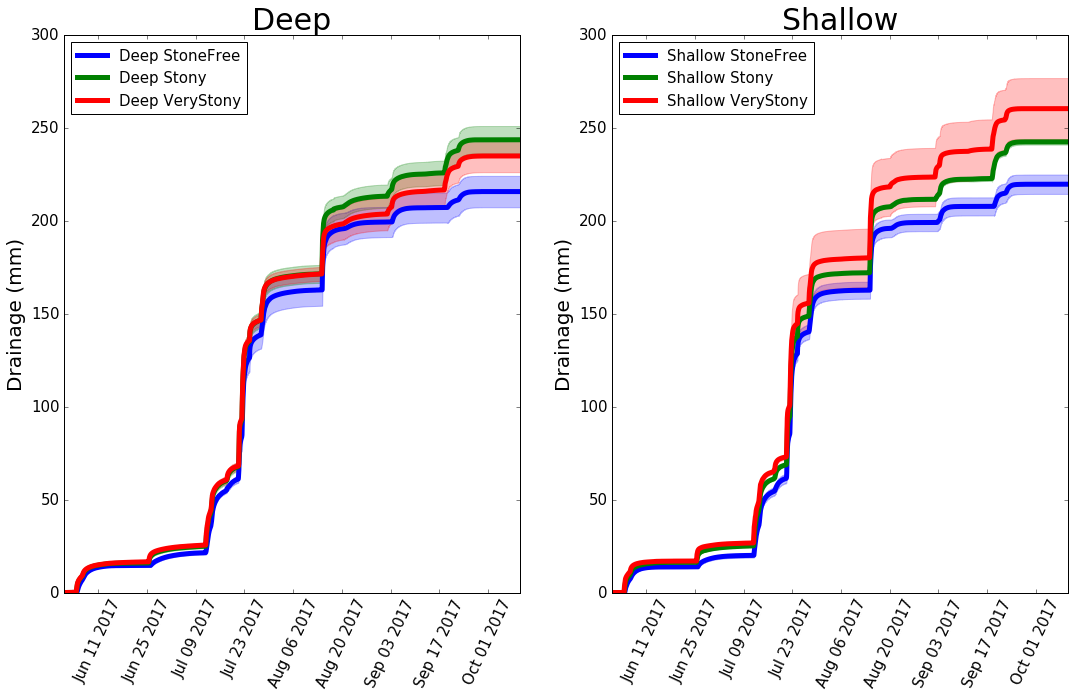

In [19]:
Gravels = ['Deep','Shallow']
Stones = ['StoneFree','Stony','VeryStony']
lines = ['-','--']
colors = ['b','g','r']

Graph = plt.figure(figsize=(18,10))

GravPos = 0
for Grav in Gravels:
    fig = Graph.add_subplot(1,2,GravPos+1)
    StonPos = 0
    for Ston in Stones:
        median = Drainage.ix['2017-06-01':,(Grav,Ston)].cumsum().median(axis=1)
        SEM = Drainage.ix['2017-06-01':,(Grav,Ston)].cumsum().std(axis=1)/np.sqrt(4)
        Upper = median + SEM
        Lower = median - SEM
        plt.fill_between(Drainage.ix['2017-06-01':,(Grav,Ston)].index,
                 Upper,
                 Lower,
                 color = colors[StonPos],alpha=0.25)
        plt.plot(Drainage.ix['2017-06-01':,(Grav,Ston)].index,median,color=colors[StonPos],
                 linewidth = 5,
                 label = Grav+' ' +Ston)
        StonPos += 1
        plt.title(Grav, fontsize=30)
    GravPos +=1
    plt.ylim(0,300)
    plt.ylabel('Drainage (mm)', fontsize=20)
    plt.xticks(rotation=65)
    plt.tick_params(labelsize=15)    
    plt.legend(loc=2,numpoints=1,fontsize = 15)
plt.tight_layout

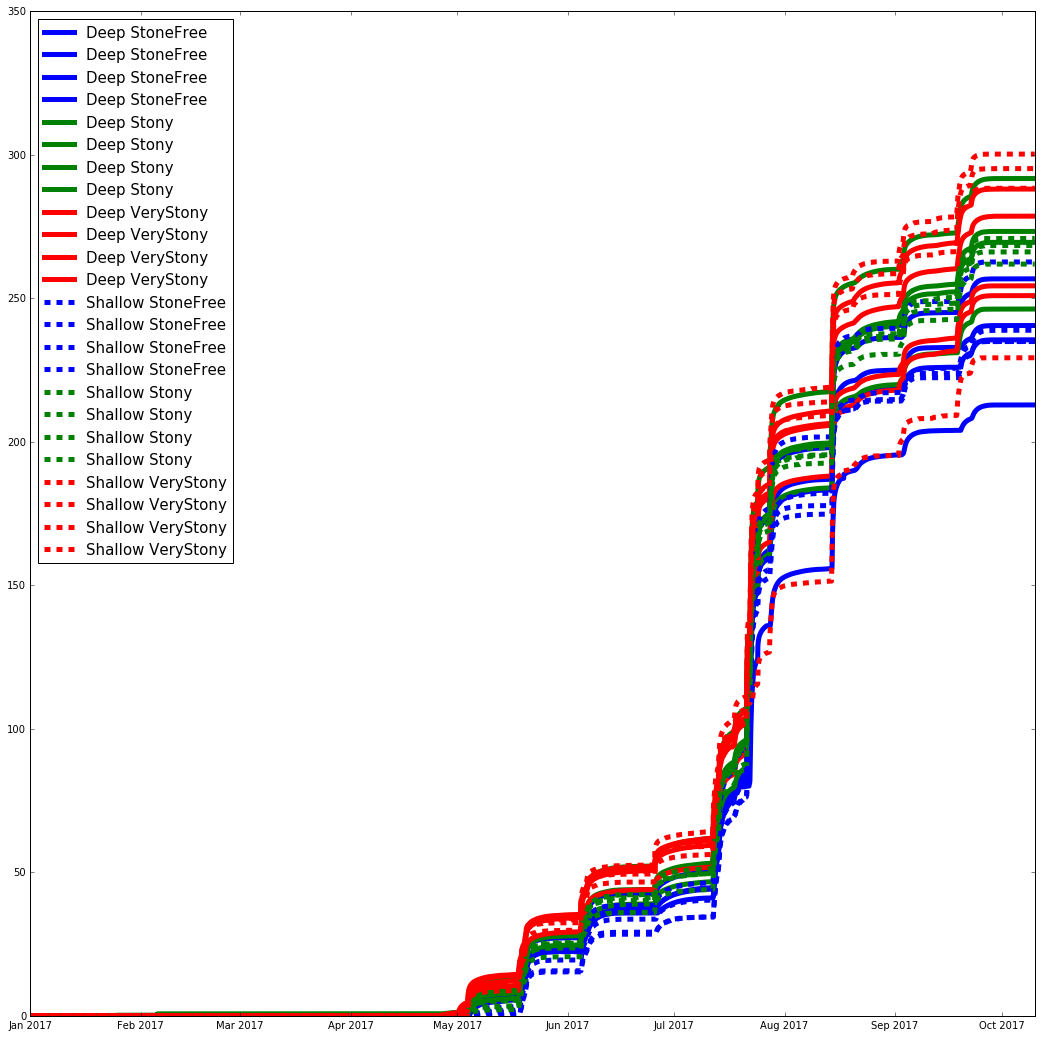

In [20]:
Gravels = ['Deep','Shallow']
Stones = ['StoneFree','Stony','VeryStony']
lines = ['-','--']
colors = ['b','g','r']

fig = plt.figure(figsize=(18,18))

GravPos = 0
for Grav in Gravels:
    StonPos = 0
    for Ston in Stones:
        plt.plot(Drainage.ix['2017-01-01':,(Grav,Ston)].index,
                 Drainage.ix['2017-01-01':,(Grav,Ston)].cumsum(),
                 lines[GravPos],
                color = colors[StonPos],
                linewidth = 5,
                label = Grav+' ' +Ston)
        StonPos += 1
    GravPos +=1
plt.legend(loc=2,numpoints=1,fontsize = 15)


In [21]:
DailyDrainage.to_pickle('.\Dataframes\Drainage')